In [236]:
%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import *    
import os 
import pyreadr
import numpy as np
import pyreadr
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
import butterfly.album
import butterfly.Models
from itertools import combinations 
from joblib import parallel_backend
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import r2_score
import pickle
from sklearn.model_selection import GroupKFold
from random import sample
from scipy import stats
from sklearn.metrics import mean_absolute_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
n_samples = 5 #features to sample from each dataset
pixels = 40 #image size
perplexity = 25 #perplexity for the tsne

#Model
nruns = 1 #number of runs
folds = 10 #number of folds
features = 1 #number of features to predict
epochs = 180 #number of epochs
optimiser = 'adam' #model optimiser
loss = 'mse' #model loss
ntrees = 100

In [238]:
#Import your data
#DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

In [239]:
#Define the predictor datasets
omics = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']

In [241]:
pic = butterfly.album.create_album(DF, predictors, pixels, perplexity)

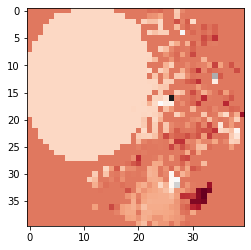

In [242]:
plot_im = plt.imshow(pic[0], cmap = 'RdGy')

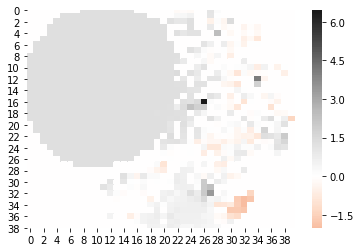

In [243]:
import seaborn as sns
plot_im = sns.heatmap(pic[0], cmap = 'RdGy', center = 0)

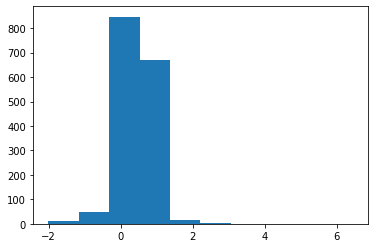

In [244]:
plt.hist(pic[0].flatten());

In [ ]:
albums = []
for predictor_index in tqdm(range(len(omics))):
    
    #Get your predictor dataset
    predictors = list(omics)
    predictors.remove(omics[predictor_index])
    predictors = tuple(predictors)

    albums.append(butterfly.album.create_album(DF, predictors, pixels, perplexity))

In [ ]:
with open('albums.pkl', 'wb') as f:  
    pickle.dump(albums, f)

In [110]:
with open('albums.pkl', 'rb') as f:
    albums = pickle.load(f)

In [111]:
RF_predictor = []
for predictor_index in tqdm(range(len(omics))):
    
    #Get your predictor dataset
    DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
    DF = DF["DF"]

    unwanted = DF.columns[DF.columns.str.startswith(omics[predictor_index])]
    DF.drop(unwanted, axis=1, inplace=True)
    DF.drop(['patient_TR', 'patientID', 'trimester'], axis=1, inplace=True)

    RF_predictor.append(DF)





  0%|          | 0/7 [00:00<?, ?it/s]



 14%|█▍        | 1/7 [00:02<00:13,  2.31s/it]



 29%|██▊       | 2/7 [00:04<00:11,  2.36s/it]



 43%|████▎     | 3/7 [00:07<00:09,  2.36s/it]



 57%|█████▋    | 4/7 [00:09<00:07,  2.37s/it]



 71%|███████▏  | 5/7 [00:11<00:04,  2.38s/it]



 86%|████████▌ | 6/7 [00:14<00:02,  2.38s/it]



100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


In [112]:
prediction_train_f = []
observed_train_f = []
prediction_test_f = []
observed_test_f = []

prediction_train_fR = []
observed_train_fR = []
prediction_test_fR = []
observed_test_fR = []

DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

for predictor_index in tqdm(range(len(omics))):

    #Get your response dataset
    response = sample([col for col in DF if col.startswith(omics[predictor_index])], n_samples)
    response = np.append(response, 'patientID')
    response_df = DF[response]
    
    groups = response_df['patientID']
    
    y = response_df.values
    y = response_df.drop(['patientID'], axis = 1).values
    
    #CNN
    #Get your predictor dataset
    X_CNN = np.asarray(albums[predictor_index])
    
    prediction_train_CNN = []
    observed_train_CNN = []
    prediction_test_CNN = []
    observed_test_CNN = []
    
    #RF
    #Get your predictor dataset
    X_RF = RF_predictor[predictor_index]
    X_RF = X_RF.values
    X_RF = StandardScaler().fit_transform(X_RF)
    
    prediction_train_RF = []
    observed_train_RF = []
    prediction_test_RF = []
    observed_test_RF = []

    for feat in tqdm(range(y.shape[1])):

        prediction_train, observed_train, prediction_test, observed_test = zip(*Parallel(n_jobs=nruns)
                               (delayed(butterfly.Models.CNN)
                                (X_CNN, y[:,feat], groups, pixels, features, folds, epochs, optimiser, loss) 
                                for cv in range(nruns)))                

        prediction_train_CNN.append(prediction_train)
        observed_train_CNN.append(observed_train)
        prediction_test_CNN.append(prediction_test)
        observed_test_CNN.append(observed_test)
        
        prediction_train, observed_train, prediction_test, observed_test = zip(*Parallel(n_jobs=nruns)
                               (delayed(butterfly.Models.RF)
                                (X_RF, y[:,feat], groups, folds, 'RF_regressor', ntrees) 
                                for cv in range(nruns)))                

        prediction_train_RF.append(prediction_train)
        observed_train_RF.append(observed_train)
        prediction_test_RF.append(prediction_test)
        observed_test_RF.append(observed_test)
        
    prediction_train_f.append(prediction_train_CNN)
    observed_train_f.append(observed_train_CNN)
    prediction_test_f.append(prediction_test_CNN)
    observed_test_f.append(observed_test_CNN)
    
    prediction_train_fR.append(prediction_train_RF)
    observed_train_fR.append(observed_train_RF)
    prediction_test_fR.append(prediction_test_RF)
    observed_test_fR.append(observed_test_RF)





  0%|          | 0/7 [00:00<?, ?it/s]




  0%|          | 0/7 [00:03<?, ?it/s]


ValueError: Error when checking input: expected conv1d_1_input to have shape (120, 120) but got array with shape (40, 40)

In [99]:
each_omic_CNN = []
for l in range(len(omics)):
    each_feature_CNN = []
    for k in range(n_samples):
        each_run_CNN = []
        for i in range(nruns):
            each_run_CNN.append(mean_absolute_error(prediction_test_f[l][k][i], observed_test_f[l][k][i]))
        each_feature_CNN.append(np.mean(each_run_CNN))
    each_omic_CNN.append(np.mean(each_feature_CNN))    

In [100]:
each_omic_RF = []
for l in range(len(omics)):
    each_feature_RF = []
    for k in range(n_samples):
        each_run_RF = []
        for i in range(nruns):
#            each_run_RF.append(stats.spearmanr(prediction_test_fR[l][k][i], observed_test_fR[l][k][i])[0])
            each_run_RF.append(mean_absolute_error(prediction_test_fR[l][k][i], observed_test_fR[l][k][i]))
        each_feature_RF.append(np.mean(each_run_RF))
    each_omic_RF.append(np.mean(each_feature_RF))    

In [ ]:
np.mean(each_omic_RF)

In [ ]:
np.mean(each_omic_CNN)

200.6204074353966

In [102]:
np.mean(each_omic_CNN)

234.3681512877924